#### **Use Grid Search to Find the most Informative Peaks**

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

Read the spectral data

In [2]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
df = pd.read_csv("../../data/current_clean_spectrum.csv", index_col=0)

In [3]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,134.816776
1,201210-1-00,1,200.68336,201210-1,Normal,132.968432
2,201210-1-00,2,201.36674,201210-1,Normal,131.193409
3,201210-1-00,3,202.05011,201210-1,Normal,129.491708
4,201210-1-00,4,202.73349,201210-1,Normal,127.863329
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,21.219946
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,21.661404
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,22.127722
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,22.618900


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8023575 entries, 0 to 8023574
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   SurID       object 
 4   Status      object 
 5   Absorbance  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 428.5+ MB


In [5]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber     SurID         Status  Absorbance
7981415  210526-3-04     0   200.00000  210526-3  Hyperglycemia  -23.674679
7981416  210526-3-04     1   200.68336  210526-3  Hyperglycemia  -23.996229
7981417  210526-3-04     2   201.36674  210526-3  Hyperglycemia  -24.183251
7981418  210526-3-04     3   202.05011  210526-3  Hyperglycemia  -24.235746
7981419  210526-3-04     4   202.73349  210526-3  Hyperglycemia  -24.153714
...              ...   ...         ...       ...            ...         ...
7984045  210526-3-04  2630  1997.26650  210526-3  Hyperglycemia   20.433782
7984046  210526-3-04  2631  1997.94980  210526-3  Hyperglycemia   20.220338
7984047  210526-3-04  2632  1998.63330  210526-3  Hyperglycemia   19.998315
7984048  210526-3-04  2633  1999.31670  210526-3  Hyperglycemia   19.767715
7984049  210526-3-04  2634  2000.00000  210526-3  Hyperglycemia   19.528536

[2635 rows x 6 columns]


Find Peaks Within the spectrum.

In [6]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
peaks, _ = find_peaks(x=sample['Absorbance'])

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

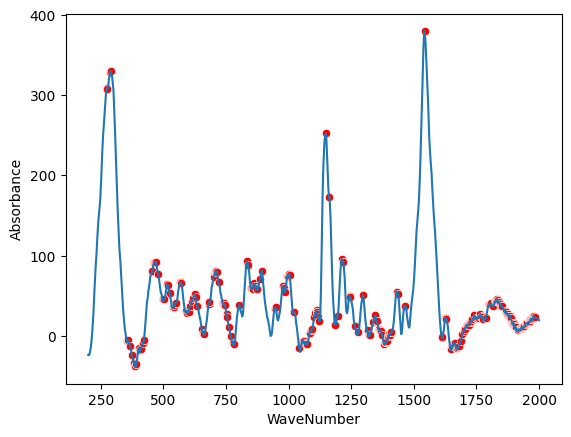

In [7]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")

As you can see, it does not properly find the peaks, so we have to tune the peak finding parameters.

These parameters are based on Thomas Keogh's Search

In [8]:
tuned_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

In [9]:
sample

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
7981415,210526-3-04,0,200.00000,210526-3,Hyperglycemia,-23.674679
7981416,210526-3-04,1,200.68336,210526-3,Hyperglycemia,-23.996229
7981417,210526-3-04,2,201.36674,210526-3,Hyperglycemia,-24.183251
7981418,210526-3-04,3,202.05011,210526-3,Hyperglycemia,-24.235746
7981419,210526-3-04,4,202.73349,210526-3,Hyperglycemia,-24.153714
...,...,...,...,...,...,...
7984045,210526-3-04,2630,1997.26650,210526-3,Hyperglycemia,20.433782
7984046,210526-3-04,2631,1997.94980,210526-3,Hyperglycemia,20.220338
7984047,210526-3-04,2632,1998.63330,210526-3,Hyperglycemia,19.998315
7984048,210526-3-04,2633,1999.31670,210526-3,Hyperglycemia,19.767715


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

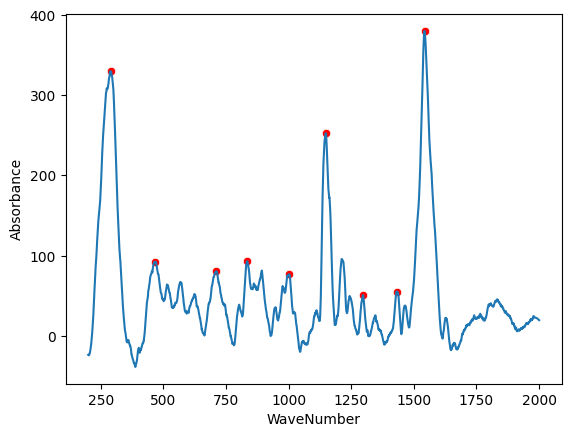

In [10]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[tuned_peaks], x="WaveNumber", y="Absorbance", color="red")

#### **Find the best Peak Finding Parameters**

Create a field for each wavelength.

In [11]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

Train an Extra Trees Classifier

In [12]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

#### **1. Using Peak Statistics**

In [13]:
backup = df

In [14]:
statuses = df[['SpecID', 'Status']].drop_duplicates()

This uses statistical properties of the peaks in each sample to be used as additional features.

In [15]:
peaks = []
widths = []
prominences = []
areas = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    #peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [16]:
peaks_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
113,201210-1-00,113,277.22095,201210-1,Normal,230.599170
389,201210-1-00,389,465.83142,201210-1,Normal,54.866643
726,201210-1-00,726,696.12756,201210-1,Normal,155.171518
1020,201210-1-00,1020,897.03870,201210-1,Normal,86.147696
1177,201210-1-00,1177,1004.32800,201210-1,Normal,73.225598
...,...,...,...,...,...,...
8008513,210526-3-49,748,711.16174,210526-3,Hyperglycemia,56.226713
8008716,210526-3-49,951,849.88611,210526-3,Hyperglycemia,41.445652
8008937,210526-3-49,1172,1000.91110,210526-3,Hyperglycemia,59.062523
8009313,210526-3-49,1548,1257.85880,210526-3,Hyperglycemia,42.796199


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

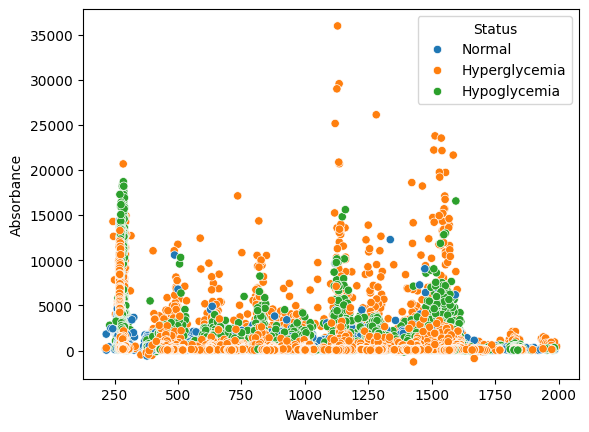

In [17]:
sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

In [18]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

24329
24329
24329


/tmp/ipykernel_3076/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_3076/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [19]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [20]:
# # Create a new DataFrame for the summary statistics
# peak_stats = peaks_df.groupby('SpecID').agg({
#     'PeakWidths': ['mean', 'std', 'max', 'min'],
#     'PeakProminences': ['mean', 'std', 'max', 'min']
# }).reset_index()

# # Flatten the multi-level columns and customize the names
# peak_stats.columns = ['SpecID',
#                       'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
#                       'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

Sometimes not every sample has a peak.

In [21]:
peak_stats.shape

(3002, 14)

In [22]:
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)

In [23]:
peak_stats.shape

(3045, 14)

In [24]:
peak_stats.head()

,Status,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,
201210-1-00,Normal,103.970546,65.378578,7.0,230.599170,54.866643,95.782670,45.756190,164.382194,48.894505,93.842580,42.619639,174.043834,47.322760
201210-1-01,Normal,141.158210,48.516456,6.0,222.768275,87.815553,87.588739,30.623744,131.433035,50.354572,129.905724,36.985714,185.001568,95.661545
201210-1-02,Normal,341.196679,391.471661,8.0,1210.352024,54.986609,60.951009,35.199884,131.019580,33.442479,337.148841,404.264444,1239.715130,49.517882
201210-1-03,Normal,724.348501,530.912748,8.0,1819.920905,101.029070,59.800100,30.168718,120.018227,32.072450,667.141079,417.608549,1340.414578,104.717517
201210-1-04,Normal,133.872272,92.740269,9.0,343.345169,61.120510,76.550049,29.873933,132.252771,31.837470,128.451061,68.248661,241.703013,63.089181


In [25]:
evaluate_extra_trees(peak_stats)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6851 +/- 0.0201


##### **Find the best Peak Finding Parameters for the Stat Based Approach**

In [26]:
peaks = []
widths = []
prominences = []
areas = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=distance, prominence=prominence, width=width)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]
peaks_df

# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

peak_stats.shape
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)
evaluate_extra_trees(peak_stats)

KeyError: "Column(s) ['PeakProminences', 'PeakWidths'] do not exist"

#### **2. Creating a uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

First get the peak properties

In [32]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

24329
24329
24329


/tmp/ipykernel_2656/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_2656/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [33]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
113,201210-1-00,113,277.22095,201210-1,Normal,230.599170,70.316585,119.994549
389,201210-1-00,389,465.83142,201210-1,Normal,54.866643,72.606738,47.322760
726,201210-1-00,726,696.12756,201210-1,Normal,155.171518,48.894505,174.043834
1020,201210-1-00,1020,897.03870,201210-1,Normal,86.147696,114.467949,98.489173
1177,201210-1-00,1177,1004.32800,201210-1,Normal,73.225598,145.119300,81.991657


Assign Peaks to bins of a fixed wavelength interval.

In [34]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_2656/464682704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [35]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
113,201210-1-00,113,277.22095,201210-1,Normal,230.599170,70.316585,119.994549,275-300
389,201210-1-00,389,465.83142,201210-1,Normal,54.866643,72.606738,47.322760,450-475
726,201210-1-00,726,696.12756,201210-1,Normal,155.171518,48.894505,174.043834,675-700
1020,201210-1-00,1020,897.03870,201210-1,Normal,86.147696,114.467949,98.489173,875-900
1177,201210-1-00,1177,1004.32800,201210-1,Normal,73.225598,145.119300,81.991657,1000-1025


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to False.
If multiple peaks appear their properties are aggregated.

In [36]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(0, inplace=True)

In [37]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,73.225598,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,114.467949,0.000000,0.0,0.0,0.0,Normal
201210-1-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,99.589230,0.0,0.0,0.0,Normal
201210-1-02,0.000000,94.726687,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,34.050327,0.0,0.0,0.0,Normal
201210-1-03,0.000000,0.000000,0.0,0.0,0.0,0.0,516.546765,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,59.789868,0.0,0.0,0.0,Normal
201210-1-04,76.128652,0.000000,0.0,0.0,0.0,0.0,0.000000,61.12051,0.0,0.0,...,0.0,0.0,0.0,132.252771,0.000000,0.000000,0.0,0.0,0.0,Normal


In [38]:
evaluate_extra_trees(peak_bins)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8111 +/- 0.0223
